---

#University of Stirling - Spring 2023

## ITNPAI1 - Deep Learning for Vision and NLP (2022/3)

---

# Assignment Summary

In this activity, you are required to apply the knowledge acquired in this module through the design and development of a complete project for deep learning-based image pattern recognition in an application to be defined by yourself. For this, you will need to perform the following **mandatory** steps:

1. [Problem definition](#scrollTo=hglJVRRslqMn)
2. [GitHub repository](#scrollTo=ecxDhkV9qmUf)
3. [Dataset](#scrollTo=qEgFzxmWrGA9)
4. [Dataloader](#scrollTo=EDd6lLwlx4un)
5. [Proposed solution](#scrollTo=ScTrpUW8zOp4)
6. [Experimental tests and evaluations](#scrollTo=3RBW58of0ZDo)
7. [Quiz and Report](#scrollTo=ws14iV4Dp_vf)
8. [Demonstration session](#scrollTo=ShLJrPKT4SQp)


------
# 1. **Problem definition** 

The Computer Vision task that we have selected for this project is **Object Detection** and the application is **Street Litter Detection**.

Two different cities were chosen to collect the dataset:

**City A**: Falkirk, Scotland, UK; Coordinates: 56.0019° N, 3.7839° W

**City B**: Punalur, Kerala, India; Coordinates: 9.0176° N, 76.9261° E

It was made sure that the dataset images are free of any sensitive informations like faces of people or vehicle number plate information.
All the images for the dataset were captured either using a mobile camera or a standard digital camera


---
# 2. **GitHub repository**

A Github repository named **ITNPAI1-Street-Litter-Detection** was created for the project.

**Repo Link**: https://github.com/bipinthecoder/ITNPAI1-Street-Litter-Detection


---
# 3. **Dataset creation**

You must collect a minimum of **200 positive samples** from the study objects for each city (A and B). 
Note that, depending on the task being solved, it will also be necessary to: 

   (i) collect more samples - negative ones, for instance;

   (ii) annotating each image, delineating objects or creating bounding boxes. Planning and executing this correctly is important to ensure effective training of deep learning-based models.

Your dataset can be assembled from one or more of the following ways:

  - *M1* - Pictures taken by yourself on site (street view from cities A and B), with attention to anonymization issues (if it is the case). It is not allowed to assemble datasets containing people. Other sensitive patterns, such as license plates, must be properly hidden.

  - *M2* - Aerial satellite/drone images obtained from GIS and remote sensing platforms or public repositories. Be careful with unusual file formats that may be challenging to manipulate using basic image processing libraries. We recommend keeping or converting the images to jpg or png.

  - *M3* - Pictures taken from other public available datasets. Remember you are not allowed to use datasets containing people or other sensitive patterns/objects.

  - *M4* - Images crawled from the internet as a whole (social networks, webpages, etc), with special attention to use and copyrights.

  - *M5* - Textual and metadata you may need in your project, with special attention to use and copyrights (as always!).

**Important:** If you collect the images on your own or from aerial imagery repositories, it will be necessary to keep the geographic coordinates. If you collect from specific websites, please retain the source links. This information should be placed in a .csv file and made available along with the final dataset.


### Method M1 was followed to obtain the dataset

**Dataset Collection**

The Dataset for the task involves images of street litter from both the cities Falkirk and Punalur, along with some negative samples of no litter. All the photos for the study were captured using a phone or a standard digital camera. The dataset was cleared off images with sensitive data like faces, number plates of vehicles etc. 

A total of 301 images were collected, of which 178 were from Falkirk and 123 from Punalur. Limited time prevented us from collecting more images for the dataset, so we employed pre-processing data augmentation techniques to enhance the model's prediction capability.

**Annotation/Labelling**

The litter-containing images were annotated using the open-source tool, LabelImg [2], and the resulting annotations were saved in .txt format. The source code includes a function to read the bounding box coordinates from these files.



---

# 4. **Dataloader**

Here you are required to implement all the code related to pre-processing, cleaning, de-noising and preparing the input images and metadata according to the necessary data structures as input to your pattern recognition module. We recommend using [PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) or [Tensorflow (with Keras)](https://keras.io/getting_started/intro_to_keras_for_engineers/) as a base, but you are free to use any library or platform as long as it is well justified in the [final report](#scrollTo=ws14iV4Dp_vf).

[top](scrollTo=4i5afvUbhmGo)

### 4.1 Libraries and Modules

In [1]:
#Importing necessary modules and libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf


In [2]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import random

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### **Data Loading**

In [3]:
#Initializing the data variables
raw_image_path = ''
annotated_image_path = ''
raw_images = []
annotated_files = []

In [4]:

"""This function when called will set the initial file paths based on the city value"""

def set_data_path(city):
    
    path = test_path = ''
    
    if city == 'Punalur':
        path = './Punalur/Train/'
        test_path = './Punalur/Test/'
        
    elif city == 'Falkirk':
        path = './Falkirk/Train/'
        test_path = './Falkirk/Test/'
    
    raw_image_path = path + 'Images/'

    #annotated images
    annotated_image_path = path + 'Annotations'
    
    #Storing the raw Images names in a list
    raw_images = [image for image in os.listdir(raw_image_path)]
    
    return raw_image_path, annotated_image_path
    # annotated_files = read_annot_files_as_data_frames()

In [5]:
"""This function will reset the data pointers to initial values"""

def reset_data_path():
    raw_image_path = ''
    annotated_image_path = ''
    raw_images = []


### **Data Processing Routines**

In [6]:
# Image Resize function :: To resize the image passed to the specified shape.
def resize_image(img, shape):
    resized_img = cv2.resize(img, shape)
    return resized_img


In [7]:
# Function to perform Horizontal Flip operation of a passed image
def horizontal_flip(image):
    horizontal_flip = cv2.flip(image, 1)
    return horizontal_flip


In [8]:
""" This function will perform all the preprocessing steps required for a passed image """


def perform_image_preprocessing(image):

    # Normalizing the Image
    image = ((image - image.min()) / (image.max() - image.min())) * 255
    image = image.astype(np.uint8)
    
    #Sharpening the Image
    kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

    image_sharpened = cv2.filter2D(image, -1, kernel)
    

    #Histogram Equalization(Contrast Enhancement)
    image_in_yuv = cv2.cvtColor(image_sharpened, cv2.COLOR_BGR2YUV)
    image_in_yuv[:, :, 0] = cv2.equalizeHist(image_in_yuv[:, :, 0])

    image_back_in_rgb = cv2.cvtColor(image_in_yuv, cv2.COLOR_YUV2BGR)

    return image_back_in_rgb


---

# 5. **Proposed solution** 

This is where you should implement most of the code for your solution. Write the routines for training and predicting the models and any necessary intermediate steps. Post-processing functions must also be implemented here.

  - Use good programming practices, modularizing and adequately commenting on your code. Code quality will be considered in the final assessment.
Again, we recommend using [PyTorch](https://pytorch.org/tutorials/beginner/introyt.html), but you are free to use any library or platform. You just need to justify that in the [final report].

  - You can use pre-trained models as backbones or any code available on the web as a basis, but they must be correctly credited and referenced both in this notebook and in the final report. Cite the source link repository and explicitly cite the authors of it.
If you changed existing code, make it clear what the changes were.
Make it clear where your own code starts and where it ends. Note that the originality percentage of the code will be considered in the evaluation, so use external codes wisely and sparingly. **Missconduct alert:** remember that there are many tools that compare existing source code and that it is relatively easy to identify authorship. So, be careful and fair by always properly thanking the authors if you use external code.


### 1. Region-based proposal approach

In this approach, we generated a number of possible regions in an image using a region proposal agorithm called Selective Search of OpenCV. These proposals are compared against the ground truth bounding box values of litters using IOU(Intersection of Union) value. The more the intersection between the ground truth bounding boxes and the proposed region by the algorithm, the larger the value of IOU is. This in-turn was used to classify the cropped images as litter and no-litter. This classfication data is split into train and test data and is fed into a classifier to predict a proposed image in the future. The classifier that is used in this approach is VGG16.

In [9]:
"""This function will extract the top left and bottom right coordinates (x1, y1, x2, y2) 
from the .txt annotated file"""


def get_rectangle_coordinates_from_image(image, x_center, y_center, height, width, horizontally_flipped):
    H, W, _ = image.shape

    # If the image is horizontally flipped, the logic for coordinate changes
    if horizontally_flipped:
        x1 = int((1 - x_center - width / 2) * W)
        x2 = int((1 - x_center + width / 2) * W)

    else:
        x1 = int((x_center - width / 2) * W)
        x2 = int((x_center + width / 2) * W)

    y1 = int((y_center - height / 2) * H)
    y2 = int((y_center + 3 * height / 2) * H)
    return x1, y1, x2, y2


In [10]:
def read_annot_files_as_data_frames(annot_files_path):
    """This block of code ensures all the .txt labeled files are read as Pandas DataFrames
    with appropriate column names"""

    print(annotated_image_path)
    txt_files = [f for f in os.listdir(annot_files_path) if f.lower().endswith('.txt')]

    # Making sure the label class file is removed before further processing

    try:
        txt_files.remove('classes.txt')
    except ValueError:
        pass

    # Reading the content of each .txt file and storing in a list for easy access

    annotated_files = []
    for txt_file in txt_files:
        file_path = os.path.join(annot_files_path, txt_file)
        with open(file_path, 'r') as f:
            cols = ['label_class', 'x_center', 'y_center', 'width', 'height']
            content = pd.read_csv(f, sep=' ', names=cols)
            annotated_files.append({txt_file: content})

    return annotated_files


In [11]:
"""Region Proposal Using Selective Search algorithm """

def perform_region_proposal(image):
    # Perform region proposals using Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    # ss.switchToSelectiveSearchFast()
    ss.switchToSelectiveSearchQuality()
    regions = ss.process()
    return regions


In [12]:
"""Function to Calculate the Intersection of Region (IOU) between two dictionary of coordinates passed"""


def calculate_iou(box1, box2):
    # Calculate intersection area
    x1 = max(box1['x1'], box2['x1'])
    y1 = max(box1['y1'], box2['y1'])
    x2 = min(box1['x2'], box2['x2'])
    y2 = min(box1['y2'], box2['y2'])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate union area
    box1_area = (box1['x2'] - box1['x1'] + 1) * (box1['y2'] - box1['y1'] + 1)
    box2_area = (box2['x2'] - box2['x1'] + 1) * (box2['y2'] - box2['y1'] + 1)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou



In [13]:
"""Function to return the cropped and resized Image suitable
 for the classifier VGG16"""


def rectang_from_image(image, x, y, w, h):
    timage = image[y: y + h, x: x + w]
    resized = cv2.resize(timage,
                         (224, 224),
                         interpolation=cv2.INTER_AREA)
    return resized


In [14]:
"""This function takes a list of images,
 perform horizontal flipping for each image
and returns list of sets with the flipped image value and the image file name"""


def perform_image_flipping(list_of_images, raw_image_path):
    horizontally_flipped_images_list = []

    for raw_image in list_of_images:
        image_to_process_path = os.path.join(raw_image_path, raw_image)
        image_ = cv2.imread(image_to_process_path)
        image_to_process = image_.copy()

        horizontal_flipped_image = horizontal_flip(image_to_process)
        flipped_image_set = (horizontal_flipped_image, raw_image)
        horizontally_flipped_images_list.append(flipped_image_set)

    return horizontally_flipped_images_list


In [15]:
#Maximum proposals and samples to consider
max_proposal = 2000
max_samples = 200

#Defining the threshold values to distinguish the litter and background
IOU_treshold_litter = 0.7
IOU_treshold_background = 0.3

In [16]:
"""Given an annotated .txt file and corresponding Image, 
this function returns the coordinates of the bounding box for image"""


def get_annotation_coord_from_txt(annotated_file, image, is_flipped):
    box_values_from_annot_file = []

    for index, row in annotated_file.iterrows():
        class_label = row['label_class']
        x_center = row['x_center']
        y_center = row['y_center']
        height = row['height']
        width = row['width']
        x1, y1, x2, y2 = get_rectangle_coordinates_from_image(image, x_center, y_center, height, width, is_flipped)
        box_obj = {"x1": x1, "y1": y1, "x2": x2, "y2": y2}
        box_values_from_annot_file.append(box_obj)
    return box_values_from_annot_file


In [17]:
"""Given an annotated .txt file and corresponding image,
this function calls get_annotation_coord_from_txt() for proper coordinates or return [] if file does not exist"""

def find_and_get_box_values_from_txt(file_name, file_list, image, is_flipped):
    annot_file = pd.DataFrame()
    for item in file_list:
        # checking if file_name is in the dictionary key
        if file_name in item:
            annot_file = item[file_name]
            break

    if annot_file.empty:
        return [{"x1": 0, "y1": 0, "x2": 0, "y2": 0}]
    else:
        box_values = get_annotation_coord_from_txt(annot_file, image, is_flipped)
        return box_values


In [18]:
"""This function resizes the passed image to a suitable size for region proposal
while keeping the aspect ratio"""


def resize_for_region_proposal(to_resize_image):
    h, w, _ = to_resize_image.shape

    # Determining which side is longer
    if h > w:
        # Resizing the image to make sure longer side is 600px,(Randomly chose 600px)
        img_resized_for_proposal = cv2.resize(to_resize_image, (int(w * 600 / h), 600))
    else:
        img_resized_for_proposal = cv2.resize(to_resize_image, (600, int(h * 600 / w)))

    return img_resized_for_proposal


In [19]:
"""This function when passed with a list of images/image file name and flipped
status, performs selctive search and classifies the proposed regions as litter or
background. This is then returned separately as train images and train labels"""


def populate_training_images_labels(list_of_images, is_flipped, raw_image_path, annot_file_path):
    # Initializing the train images and train labels to populate with respective values

    train_images = []
    train_labels = []

    annot_files_list = read_annot_files_as_data_frames(annot_file_path)

    if not is_flipped:
        text_for_progress = 'Raw Image Processing'
    else:
        text_for_progress = 'Augmented Image Processing'

    # Iterating through each raw image
    for count, image_file in enumerate(tqdm(list_of_images, text_for_progress)):
        try:
            box_values_from_annot_file = []

            if is_flipped == False:
                image_to_process_path = os.path.join(raw_image_path, image_file)
                image_ = cv2.imread(image_to_process_path)
            else:
                image_ = image_file[0]

            image_to_process = image_.copy()
            image_to_process = cv2.cvtColor(image_to_process, cv2.COLOR_BGR2RGB)

            # Performing preprocessing to the image
            image_to_process = perform_image_preprocessing(image_to_process)

            try_image = image_to_process.copy()
            try_image = resize_for_region_proposal(try_image)

            # Getting corresponding Annotation file
            if is_flipped == False:
                annot_file_name = image_file.replace(".jpg", ".txt")

            else:
                annot_file_name = image_file[1].replace(".jpg", ".txt")

            coordinates_from_annot_file = find_and_get_box_values_from_txt(annot_file_name, annot_files_list, try_image,
                                                                           is_flipped)

            box_values_from_annot_file.extend(coordinates_from_annot_file)

            # Performing Region Proposal and getting the result
            selective_search_results = perform_region_proposal(try_image)

            counter = flag = falsecounter = fflag = bflag = 0

            for e, result in enumerate(selective_search_results):
                if e < max_proposal and flag == 0:
                    for a_box in box_values_from_annot_file:
                        x, y, w, h = result

                        # Calculating the IOU value of Region propsal results
                        # and annotated file coordinates(ground truth)
                        iou = calculate_iou(a_box, {"x1": x, "x2": x + w, "y1": y, "y2": y + h})
                        if counter < max_samples:
                            if iou >= IOU_treshold_litter:
                                train_images.append(rectang_from_image(try_image, x, y, w, h))
                                train_labels.append(1)
                                counter += 1
                        else:
                            fflag = 1
                        if falsecounter < max_samples:
                            if iou < IOU_treshold_background:
                                train_images.append(rectang_from_image(try_image, x, y, w, h))
                                train_labels.append(0)
                                falsecounter += 1
                        else:
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        flag = 1
        except:
            print(f'Exception for the file {image_file}')

    return train_images, train_labels


In [20]:
#Defining the model and selecting the layers
vggmodel = VGG16(weights='imagenet', include_top=True)

# Freezing the weights of the base model
for layer in vggmodel.layers:
    layer.trainable = False

# Adding a new dense layer with ReLU activation
X = Flatten(name = 'flatten2')(vggmodel.output)
X = Dense(256, activation='relu')(X)

# Adding the final dense layer with sigmoid activation for binary classification
predictions = Dense(1, activation="sigmoid")(X)
model_final = Model(inputs = vggmodel.input,outputs = predictions)

# opt = Adam(lr=0.0001)
opt = SGD(lr=0.0001)
model_final.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model_final.summary()

2023-04-11 13:37:46.214255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 13:37:46.578375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3370 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
def perform_model_training(city_name, raw_image_path, annot_file_path):
    set_data_path(city_name)
    # print(f'path is {annotated_image_path}')

    # Populating Raw Image List and Augmented Image List
    list_of_images = os.listdir(raw_image_path)
    horizontally_flipped_image_list = perform_image_flipping(list_of_images, raw_image_path)

    # Declaring variables for passing to classifier
    train_images_for_modelling = []
    train_labels_for_modelling = []

    # Processing Raw Images to populate train images and train labels

    # Raw Image processing
    train_images_of_raw_images, train_labels_of_raw_images = populate_training_images_labels(os.listdir(raw_image_path), False, raw_image_path, annot_file_path)

    # Augmented Image Processing
    train_images_of_augmented_images, train_labels_of_augmented_images = populate_training_images_labels(
        horizontally_flipped_image_list, True, raw_image_path, annot_file_path)

    # Extending Raw Images and Labels
    train_images_for_modelling.extend(train_images_of_raw_images)
    train_labels_for_modelling.extend(train_labels_of_raw_images)

    # Extending Augmented Images and Labels
    train_images_for_modelling.extend(train_images_of_augmented_images)
    train_labels_for_modelling.extend(train_labels_of_augmented_images)

    X_new = np.array(train_images_for_modelling)
    y_new = np.array(train_labels_for_modelling)

    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.10)

    train_data = ImageDataGenerator().flow(x=X_train, y=y_train)
    train_data = ImageDataGenerator().flow(x=X_test, y=y_test)

    checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5",
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto', period=1)

    early = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=100,
                          verbose=1,
                          mode='auto')

    hist = model_final.fit_generator(generator=train_data,
                                     steps_per_epoch=10,
                                     epochs=10,
                                     validation_data=train_data,
                                     validation_steps=2,
                                     callbacks=[checkpoint, early])
    
    
    
    reset_data_path()
    

    return model_final, hist


### Importing Libraries for Yolo

In [ ]:
pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.0/511.0 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.9 MB/s eta 0:00:00


### Defining YOLO Models for cities

In [ ]:
from ultralytics import YOLO

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#Loading YOLO - V8 Medium  for City Falkirk

#model = YOLO("/content/drive/MyDrive/Litter Detection.v1i.yolov8/Falkirk_Punalur/data.yaml")  # build a new model from scratch
model = YOLO("yolov8m.pt")  # load a pretrained model

100%|██████████| 49.7M/49.7M [00:00<00:00, 154MB/s]


In [ ]:
#Loading YOLO - V8 Small  for City Punalur
#model = YOLO("/content/drive/MyDrive/Litter Detection.v1i.yolov8/Falkirk_Punalur/data.yaml")  # build a new model from scratch
model = YOLO("yolov8s.pt")  # loading a pretrained model

100%|██████████| 21.5M/21.5M [00:00<00:00, 138MB/s]


---

# 6. **Experimental tests and evaluations** 


Here you must implement your code for training, testing and evaluating your solution. For this, the following code blocks (*E1*, *E2*, and *E3*) are mandatory:

  - *E1* - Training the models. Implement code to call the dataloaders implemented for training your models.  Make routines to test different parameters of your models. Plot graphs that illustrate how parameters impact model training. Compare. Train and select a model for each city (A and B) and justify. You should use half (50%) of the samples from each dataset for training and leave the other half for testing (50%). 

[top](#scrollTo=4i5afvUbhmGo)

## E1: Training

### Approach using Region based proposal

### City:Punalur

In [22]:
#Setting Data paths to Punalur directory
raw_img_path, annotated_img_path = set_data_path('Punalur')
print(raw_img_path)
# read_annot_files_as_data_frames(annotated_img_path)
model_punalur, hist = perform_model_training('Punalur', raw_img_path, annotated_img_path)


./Punalur/Train/Images/



Raw Image Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Augmented Image Processing:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2079977/1470815033.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator=train_data,


Epoch 1/10


2023-04-11 12:54:28.552010: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-11 12:54:29.901564: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 12:54:31.227653: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-11 12:54:31.227696: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-11 12:54:31.325077: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

10/10 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.8316
Epoch 1: val_loss improved from inf to 0.68838, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 18s 1s/step - loss: 0.6890 - accuracy: 0.8316 - val_loss: 0.6884 - val_accuracy: 0.8906
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.8625
Epoch 2: val_loss did not improve from 0.68838
10/10 [==============================] - 4s 398ms/step - loss: 0.6883 - accuracy: 0.8625 - val_loss: 0.6885 - val_accuracy: 0.8594
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.8844
Epoch 3: val_loss improved from 0.68838 to 0.68800, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 9s 1s/step - loss: 0.6883 - accuracy: 0.8844 - val_loss: 0.6880 - val_accuracy: 0.8594
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.9000
Epoch 4: val_loss improved f

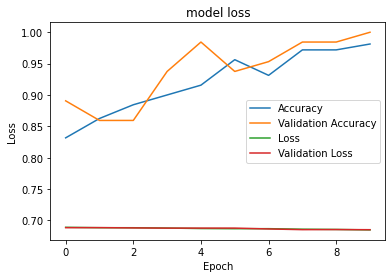

In [23]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss","Validation Loss"])
plt.show()

### City:Falkirk

In [22]:
#Setting Data paths to Punalur directory
raw_img_path, annotated_img_path = set_data_path('Falkirk')
print(raw_img_path)

model_falkirk, hist_falkirk = perform_model_training('Falkirk', raw_img_path, annotated_img_path)

./Falkirk/Train/Images/



Raw Image Processing:   0%|          | 0/147 [00:00<?, ?it/s]

Augmented Image Processing:   0%|          | 0/147 [00:00<?, ?it/s]

/tmp/ipykernel_1721013/1470815033.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_final.fit_generator(generator=train_data,


Epoch 1/10


2023-04-11 14:02:59.323711: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-11 14:03:00.663545: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 14:03:01.961089: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-11 14:03:01.962399: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-11 14:03:02.052872: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to al

10/10 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.1906
Epoch 1: val_loss improved from inf to 0.69506, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 18s 1s/step - loss: 0.6958 - accuracy: 0.1906 - val_loss: 0.6951 - val_accuracy: 0.2500
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.1937
Epoch 2: val_loss did not improve from 0.69506
10/10 [==============================] - 4s 388ms/step - loss: 0.6958 - accuracy: 0.1937 - val_loss: 0.6951 - val_accuracy: 0.2188
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.2594
Epoch 3: val_loss improved from 0.69506 to 0.69487, saving model to ieeercnn_vgg16_1.h5
10/10 [==============================] - 10s 1s/step - loss: 0.6952 - accuracy: 0.2594 - val_loss: 0.6949 - val_accuracy: 0.2344
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.3187
Epoch 4: val_loss improved 

In [23]:
print(model_falkirk)

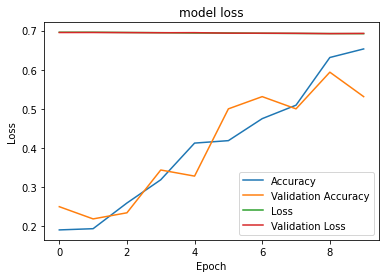

In [23]:
import matplotlib.pyplot as plt
plt.plot(hist_falkirk.history['accuracy'])
plt.plot(hist_falkirk.history['val_accuracy'])
plt.plot(hist_falkirk.history['loss'])
plt.plot(hist_falkirk.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss","Validation Loss"])
plt.show()

### 2. Approach using YOLO family of algotithms

In this approach, we used 2 different architectures from YOLO, YOLO-V8 Medium and YOLO-V8 small to accomplish the task.

### City:Falkirk

In [ ]:
#Model Training
!yolo task=detect mode=train model=yolov8m.pt data="/content/drive/MyDrive/Falkirk/data.yaml" epochs=30  # train the model

Ultralytics YOLOv8.0.71 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Falkirk/data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, d

### City:Punalur

In [ ]:
#Model Training
!yolo task=detect mode=train model=yolov8m.pt data="/content/drive/MyDrive/Punalur/data.yaml" epochs=30  # train the model

100% 49.7M/49.7M [00:00<00:00, 343MB/s]
Ultralytics YOLOv8.0.72 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Punalur/data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, ker

In [ ]:
#MODEL EXTRACTION FOR FALKIRK
success = model.export(format="onnx")  # export the model to ONNX format

Ultralytics YOLOv8.0.71 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from yolov8m.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 96.2 MB/s eta 0:00:00

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.13.1 opset 17...


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 10.6s, saved as yolov8m.onnx (99.0 MB)

Export complete (15.0s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8m.onnx imgsz=640 
Validate:        yolo val task=detect model=yolov8m.onnx imgsz=640 data=coco.yaml 
Visualize:       https://netron.app


In [ ]:
#MODEL EXTRACTION FOR PUNALUR
success = model.export(format="onnx")  # export the model to ONNX format

Ultralytics YOLOv8.0.72 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs

PyTorch: starting from yolov8s.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (21.5 MB)
requirements: YOLOv8 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 86.9 MB/s eta 0:00:00

requirements: 1 package updated per ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.13.1 opset 17...
ONNX: export success ✅ 11.2s, saved as yolov8s.onnx (42.8 MB)

Export complete (12.6s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8s.onnx imgsz=640 
Validate:        yolo val task=detect model=yolov8s.onnx imgsz=640 data=coco.yaml 
Visualize:       http

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



  - *E2* - Testing the models in the dataset. You must implement code routines to test the predictive ability of your models using half of each dataset intended for testing. **The model trained in city A must be tested in city A. The model trained in city B must be tested in city B.** Use the evaluation metrics (accuracy, F1-score, AUC, etc) that are most appropriate for your problem. Plot graphs that illustrate the results obtained for each city (A and B). Plot visual examples of correctly (true positive) and incorrectly (false positive) classified samples. 

## E2 : Testing

### Prediction for City: Falkirk

### 1. RCNN Prediction for Falkirk

1/1 [==============================] - 0s 14ms/step


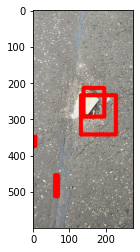

In [67]:
# img=random.choice(images)
# img = cv2.imread('./Falkirk/Test/Images/20230304_142518.jpg')
count = 0
img = cv2.imread('./Falkirk/Test/Images/20230306_093500.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = resize_for_region_proposal(img)
# img = cv2.imread(os.path.join(path,img))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
# ss.switchToSelectiveSearchFast()
ss.switchToSelectiveSearchQuality()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_falkirk.predict(img)
        if out[0][0] > 0.506:
            count += 1
            if count < 5: #Removing redundant bounding boxes for visual clarity
                cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 10, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)

### 2. YOLO Prediction for Falkirk

**GitHub Repo Link for Falkirk model predictions on Falkirk dataset** : https://github.com/bipinthecoder/ITNPAI1-Street-Litter-Detection/tree/main/models/YoloV8m_Falkirk/content/Prediction_Falkirk_model_on_Falkirk_data

**GitHub Repo Link for Falkirk model predictions on Punalur dataset** : https://github.com/bipinthecoder/ITNPAI1-Street-Litter-Detection/tree/main/models/YoloV8m_Falkirk/content/Prediction_Falkirk_model_on_Punalur_data/detect   

In [ ]:
#MODEL PREDICTION FOR FALKIRK
!yolo task=detect \
mode=predict \
model="C:\Users\ASUS\Downloads\YoloV8m_Falkirk\YoloV8m_Falkirk\content\runs\detect\train2\weights\best.pt" \
conf=0.15 \
source="C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Falkirk\train\images\20230304_145253.jpg" \
save = True \
show = True

2023-04-11 13:07:31.428595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-11 13:07:31.429396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Ultralytics YOLOv8.0.54  Python-3.8.8 torch-2.0.0+cpu CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Falkirk\train\images\20230304_145253.jpg: 320x640 2 trashs, 860.3ms
Speed: 5.0ms preprocess, 860.3ms inference, 32.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


In [ ]:
#MODEL PREDICTION FOR FALKIRK
!yolo task=detect \
mode=predict \
model="C:\Users\ASUS\Downloads\YoloV8m_Falkirk\YoloV8m_Falkirk\content\runs\detect\train2\weights\best.pt" \
conf=0.15 \
source="C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Falkirk\train\images\20230304_160819.jpg" \
save = True \
show = True

2023-04-11 13:08:12.649517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-11 13:08:12.650198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Ultralytics YOLOv8.0.54  Python-3.8.8 torch-2.0.0+cpu CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Falkirk\train\images\20230304_160819.jpg: 640x320 2 trashs, 595.7ms
Speed: 3.6ms preprocess, 595.7ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict2


In [ ]:
#MODEL PREDICTION FOR FALKIRK
!yolo task=detect \
mode=predict \
model="C:\Users\ASUS\Downloads\YoloV8m_Falkirk\YoloV8m_Falkirk\content\runs\detect\train2\weights\best.pt" \
conf=0.40 \
source="C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Falkirk\train\images\20230304_161002.jpg" \
save = True \
show = True

2023-04-11 13:08:29.335973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-11 13:08:29.336015: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Ultralytics YOLOv8.0.54  Python-3.8.8 torch-2.0.0+cpu CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Falkirk\train\images\20230304_161002.jpg: 640x320 1 trash, 910.4ms
Speed: 1.0ms preprocess, 910.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3


### Prediction for City: Punalur

### 1. RCNN Prediction

1/1 [==============================] - 0s 13ms/step


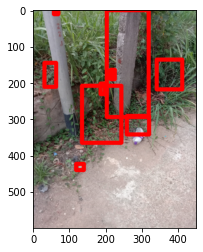

In [29]:

count = 0
img = cv2.imread('./Punalur/Test/Images/IMG_20230321_183157.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = resize_for_region_proposal(img)
# img = cv2.imread(os.path.join(path,img))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
# ss.switchToSelectiveSearchFast()
ss.switchToSelectiveSearchQuality()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_punalur.predict(img)
        if out[0][0] > 0.3:
            count += 1
            if count < 10: #Removing redundant bounding boxes for visual clarity
                cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 10, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)

### 2. YOLO Prediction for Punalur

**GitHub Repo Link for Punalur model predictions on Falkirk dataset** : https://github.com/bipinthecoder/ITNPAI1-Street-Litter-Detection/tree/main/models/YoloV8s_Punalur/content/Prediction_Punalur_model_on_Falkirk_data

**GitHub Repo Link for Punalur model predictions on Punalur dataset** : https://github.com/bipinthecoder/ITNPAI1-Street-Litter-Detection/tree/main/models/YoloV8s_Punalur/content/Prediction_Punalur_model_on_Punalur_data       

In [ ]:
#MODEL PREDICTION FOR PUNALUR
!yolo task=detect \
mode=predict \
model="C:\Users\ASUS\Downloads\YoloV8s_Punalur_30 epochs\content\runs\detect\train\weights\best.pt" \
conf=0.15 \
source="C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Punalur\train\images\WhatsApp Image 2023-03-25 at 11.50.40.jpeg" \
save = True \
show = True

2023-04-11 13:14:50.776276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-11 13:14:50.776332: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Ultralytics YOLOv8.0.54  Python-3.8.8 torch-2.0.0+cpu CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Punalur\train\images\WhatsApp Image 2023-03-25 at 11.50.40.jpeg: 640x288 1 trash, 534.3ms
Speed: 1.0ms preprocess, 534.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict3


In [ ]:
*GitHub repo link for Punalur model Prediction*

In [ ]:
#MODEL PREDICTION FOR PUNALUR
!yolo task=detect \
mode=predict \
model="C:\Users\ASUS\Downloads\YoloV8s_Punalur_30 epochs\content\runs\detect\train\weights\best.pt" \
conf=0.15 \
source="C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Punalur\test\images\IMG_20230321_183157.jpg" \
save = True \
show = True

2023-04-11 13:14:34.772202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-11 13:14:34.773987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Ultralytics YOLOv8.0.54  Python-3.8.8 torch-2.0.0+cpu CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Punalur\test\images\IMG_20230321_183157.jpg: 640x480 1 trash, 884.1ms
Speed: 3.5ms preprocess, 884.1ms inference, 20.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict2


In [ ]:
#MODEL PREDICTION FOR PUNALUR
!yolo task=detect \
mode=predict \
model="C:\Users\ASUS\Downloads\YoloV8s_Punalur_30 epochs\content\runs\detect\train\weights\best.pt" \
conf=0.15 \
source="C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Punalur\valid\images\IMG_20230321_184216.jpg" \
save = True \
show = True

2023-04-11 13:14:15.116647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-11 13:14:15.117425: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Ultralytics YOLOv8.0.54  Python-3.8.8 torch-2.0.0+cpu CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 C:\Users\ASUS\OneDrive\Documents\Academics\Spring Sem\Deep Learning\Punalur\valid\images\IMG_20230321_184216.jpg: 640x480 1 trash, 1097.0ms
Speed: 3.3ms preprocess, 1097.0ms inference, 26.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


**Github Repo for prediction of model trained on Falkirk and Punalur data together** : https://github.com/bipinthecoder/ITNPAI1-Street-Litter-Detection/tree/main/models/Yolov8s_Falkirk_Punalur_combined/runs

In [ ]:
#Saving Predictions
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/predict3/ (stored 0%)
  adding: content/runs/detect/predict3/Copy of WhatsApp Image 2023-03-25 at 11.50.40.jpg (deflated 4%)
  adding: content/runs/detect/predict/ (stored 0%)
  adding: content/runs/detect/predict/Copy of WhatsApp Image 2023-03-25 at 11.50.12.jpg (deflated 3%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/events.out.tfevents.1681134443.c9fe08a455ec.1083.0 (deflated 70%)
  adding: content/runs/detect/train/train_batch2.jpg (deflated 4%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 2%)
  adding: content/runs/detect/train/labels.jpg (deflated 50%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 5%)
  adding: content/runs/detect/train/R_curve.png (deflated 16%)
  adding: content/runs/detect/train/PR_curve.png (deflated 22%)
  adding: content/runs/detect/train/F1_curve.png (deflated 16%)
  adding

----

- *E3* - Testing the models crossing datasets. Here you must do exactly the 

same as in *E2*, but now training in one city and testing in the other. **The model trained in city A must be tested in city B. The model trained in city B must be tested in city A.** Use the same metrics and plot the same types of graphs so that results are comparable.


### E3: Cross Dataset Testing

### Testing Punalur trained models on Falkirk data

### 1. Testing RCNN

1/1 [==============================] - 0s 13ms/step


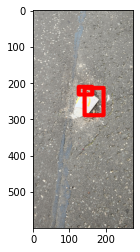

In [36]:

count = 0
img = cv2.imread('./Falkirk/Test/Images/20230306_093500.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = resize_for_region_proposal(img)
# img = cv2.imread(os.path.join(path,img))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
# ss.switchToSelectiveSearchFast()
ss.switchToSelectiveSearchQuality()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_punalur.predict(img)
        if out[0][0] > 0.5:
            count += 1
            if count < 3: #Removing redundant bounding boxes for visual clarity
                cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 10, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)

### YOLO algorithms Prediction of Punalur trained Model on Falkirk dataset

In [ ]:
# Punalur Prediction of YOLO

!yolo task=detect \
mode=predict \
model="/content/runs/detect/train/weights/best.pt" \
conf=0.15 \
source="/content/drive/MyDrive/Falkirk/Copy of WhatsApp Image 2023-03-25 at 11.50.12.jpg" \
save = True \
show = True

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.72 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /content/drive/MyDrive/Falkirk/Copy of WhatsApp Image 2023-03-25 at 11.50.12.jpg: 640x288 2 trashs, 592.2ms
Speed: 1.5ms preprocess, 592.2ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
# Punalur Prediction of YOLO

!yolo task=detect \
mode=predict \
model="/content/runs/detect/train/weights/best.pt" \
conf=0.15 \
source="/content/drive/MyDrive/Falkirk/Copy of WhatsApp Image 2023-03-25 at 11.50.40.jpeg" \
save = True \
show = True

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.72 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /content/drive/MyDrive/Falkirk/Copy of WhatsApp Image 2023-03-25 at 11.50.40.jpeg: 640x288 1 trash, 579.9ms
Speed: 0.5ms preprocess, 579.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


In [ ]:
# Punalur Prediction of YOLO

!yolo task=detect \
mode=predict \
model="/content/runs/detect/train/weights/best.pt" \
conf=0.15 \
source="/content/drive/MyDrive/Falkirk/Copy of WhatsApp Image 2023-03-25 at 11.50.40.jpg" \
save = True \
show = True

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

Ultralytics YOLOv8.0.72 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /content/drive/MyDrive/Falkirk/Copy of WhatsApp Image 2023-03-25 at 11.50.40.jpg: 640x288 1 trash, 546.3ms
Speed: 0.5ms preprocess, 546.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


### Testing Falkirk trained models on Punalur data

### 1. RCNN Model

1/1 [==============================] - 0s 13ms/step


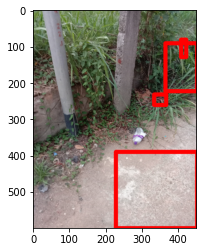

In [28]:

count = 0
img = cv2.imread('./Punalur/Test/Images/IMG_20230321_183157.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = resize_for_region_proposal(img)
# img = cv2.imread(os.path.join(path,img))
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
# ss.switchToSelectiveSearchFast()
ss.switchToSelectiveSearchQuality()
ssresults = ss.process()
imout = img.copy()
for e,result in enumerate(ssresults):
    if e < 2000:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out= model_falkirk.predict(img)
        if out[0][0] > 0.45:
            count += 1
            if count < 5: #Removing redundant bounding boxes for visual clarity
                cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 10, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)

### YOLO algorithm predictions for Falkirk trained model on Punalur dataset

In [ ]:
#Falkirk Prediction of YOLO on Punalur data

!yolo task=detect \
mode=predict \
model="/content/runs/detect/train2/weights/best.pt" \
conf=0.15 \
source="/content/drive/MyDrive/Punalur/train/images/IMG_20230407_160304.jpg" \
save = True \
show = True

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

2023-04-09 20:55:41.795650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.71 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /content/drive/.shortcut-targets-by-id/1TCN2B3V3w1yZh13WCsRuCZ_UXPUrXR58/Punalur/train/images/IMG_20230407_160304.jpg: 640x480 3 trashs, 1211.8ms
Speed: 2.4ms preprocess, 1211.8ms inference, 31.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
#Falkirk Prediction of YOLO on Punalur data

!yolo task=detect \
mode=predict \
model="/content/runs/detect/train2/weights/best.pt" \
conf=0.15 \
source="/content/drive/MyDrive/Punalur/train/images/WhatsApp Image 2023-03-25 at 11.50.12.jpg" \
save = True \
show = True

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

2023-04-09 21:00:07.562271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.71 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /content/drive/.shortcut-targets-by-id/1TCN2B3V3w1yZh13WCsRuCZ_UXPUrXR58/Punalur/train/images/WhatsApp Image 2023-03-25 at 11.50.12.jpg: 640x288 1 trash, 608.7ms
Speed: 3.9ms preprocess, 608.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict6


In [ ]:
#Falkirk Prediction of YOLO on Punalur data

!yolo task=detect \
mode=predict \
model="/content/runs/detect/train2/weights/best.pt" \
conf=0.15 \
source="/content/drive/MyDrive/Punalur/train/images/WhatsApp Image 2023-03-25 at 11.50.13.jpeg" \
save = True \
show = True

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()

2023-04-09 21:00:35.778284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.71 🚀 Python-3.9.16 torch-2.0.0+cu118 CPU
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/1 /content/drive/.shortcut-targets-by-id/1TCN2B3V3w1yZh13WCsRuCZ_UXPUrXR58/Punalur/train/images/WhatsApp Image 2023-03-25 at 11.50.13.jpeg: 640x288 4 trashs, 607.3ms
Speed: 1.3ms preprocess, 607.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7


## Remarks

- For the RCNN architecture, we had thought of implementing a function to perform the testing, however 
  due to the inconsistency in the model's predictions, threshold values had to be changed for different samples.
- In future, we believe the RCNN model could be improved by collecting more samples and tuning the model to find the
  best configuartions
- Since the result clearly states that a variety of data can enhance the accuracy of the model, we have tried training Falkirk and Punalur data together and train models which show robustness, this can be found in the Github repository.

## References

* https://blog.paperspace.com/data-augmentation-for-bounding-boxes/  -> Referred to understand coordinate changes after performing data augmentation
* ITNPAI1 - Deep Learning for Vision and NLP, Practical 9: R-CNN -> IOU function was obtained from here
* https://stackoverflow.com/questions/56115874/how-to-convert-bounding-box-x1-y1-x2-y2-to-yolo-style-x-y-w-h -> idea of converting .txt coordinates to normal bounding box coordinates